In [2]:
import os
import sys
import pathlib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display

sys.path.append(os.getcwd() + "/../")

import bfcnn

In [3]:
# setup environment
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
tf.compat.v1.enable_eager_execution()
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [4]:
# base directory for test images
IMAGES_TEST_DIR = \
    pathlib.Path(os.path.abspath('')).parent.resolve() / "images" / "test"

# directory of kitti test images
KITTI_DIR = \
    IMAGES_TEST_DIR / "kitti"

# all the kitti test images
KITTI_IMAGES = \
    [img for img in (KITTI_DIR / "files").glob("*.png")]


In [5]:
SHOW_IMAGES = False
FIG_SIZE = (24, 8)
TARGET_SIZE = (128, 384)
NOISE_STD = list(range(1, 80, 5))
RESOLUTIONS= [(128, 384), (256,768)]
#KITTI_IMAGES_SAMPLE = sample(KITTI_IMAGES, 5)
KITTI_IMAGES_SAMPLE = KITTI_IMAGES
df = \
    pd.DataFrame(
        columns=[
            "model_name", "image",
            "noise_std", "mae",
            "mse", "resolution"
        ])

for model_name in bfcnn.pretrained_models.keys():
    model = bfcnn.load_model(model_name)
    for img_path in KITTI_IMAGES_SAMPLE:
        for resolution in RESOLUTIONS:
            img = \
                tf.keras.preprocessing.image.load_img(
                    path=img_path,
                    color_mode="rgb",
                    target_size=resolution,
                    interpolation="bilinear")
            img_original = \
                tf.keras.preprocessing.image.img_to_array(
                    img=img)
            img_original = tf.cast(img_original, dtype=tf.float32)
            img_original = tf.expand_dims(img_original, axis=0)
            img_original = tf.cast(img_original, dtype=tf.uint8)

            for noise_std in NOISE_STD:
                img_noisy = \
                    tf.cast(img_original, dtype=tf.float32) + \
                    tf.random.truncated_normal(
                        mean=0,
                        stddev=noise_std,
                        shape=img_original.shape)
                img_noisy = tf.clip_by_value(img_noisy, clip_value_min=0, clip_value_max=255)
                img_noisy = tf.round(img_noisy)
                img_noisy = tf.cast(img_noisy, dtype=tf.uint8)
                img_denoised = model(img_noisy)
                # ---
                img_noisy_np = img_noisy.numpy()
                img_original_np = img_original.numpy()
                img_denoised_np = img_denoised.numpy()
                assert img_denoised_np.shape == img_original_np.shape
                assert img_denoised_np.shape == img_noisy_np.shape
                # --- calculate mae, mse
                mae = \
                    np.mean\
                        (np.abs(img_original_np.astype("float") - img_denoised_np.astype("float")),
                         axis=None)
                mse = \
                    np.mean\
                        (np.square(img_original_np.astype("float") - img_denoised_np.astype("float")),
                         axis=None)
                # --- append df
                df = \
                    df.append(
                        {
                            "mae": mae,
                            "mse": mse,
                            "image": img_path,
                            "noise_std": noise_std,
                            "model_name": model_name,
                            "resolution": resolution
                        },
                        ignore_index=True)

                # --- visualize or not
                if SHOW_IMAGES:
                    norm = plt.Normalize(0, 255)
                    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=FIG_SIZE)
                    im0 = axes[0].imshow(img_original_np[0,:,:,:], norm=norm)
                    im1 = axes[1].imshow(img_noisy_np[0,:,:,:], norm=norm)
                    im2 = axes[2].imshow(img_denoised_np[0,:,:,:], norm=norm)
                    axes[0].set_title(f"original")
                    axes[0].axis("off")
                    axes[1].set_title(f"noisy")
                    axes[1].axis("off")
                    axes[2].set_title(f"denoised")
                    axes[2].axis("off")
                    plt.tight_layout()
                    plt.show()
                    print(f"mae: {mae:0.2f}")

In [6]:
display(df)

,model_name,image,noise_std,mae,mse,resolution
0,resnet_color_laplacian_3x5_non_shared_bn_16x3x...,/home/arxwn/repositories/blind_image_denoising...,1,4.456733,54.626546,"(128, 384)"
1,resnet_color_laplacian_3x5_non_shared_bn_16x3x...,/home/arxwn/repositories/blind_image_denoising...,6,4.421197,52.160509,"(128, 384)"
2,resnet_color_laplacian_3x5_non_shared_bn_16x3x...,/home/arxwn/repositories/blind_image_denoising...,11,4.453084,50.022054,"(128, 384)"
3,resnet_color_laplacian_3x5_non_shared_bn_16x3x...,/home/arxwn/repositories/blind_image_denoising...,16,4.839688,54.203376,"(128, 384)"
4,resnet_color_laplacian_3x5_non_shared_bn_16x3x...,/home/arxwn/repositories/blind_image_denoising...,21,5.599847,64.430237,"(128, 384)"
...,...,...,...,...,...,...
3643,resnet_color_1x5_non_shared_bn_16x3x3_128x128_...,/home/arxwn/repositories/blind_image_denoising...,56,26.592577,1171.071906,"(256, 768)"
3644,resnet_color_1x5_non_shared_bn_16x3x3_128x128_...,/home/arxwn/repositories/blind_image_denoising...,61,29.070891,1404.363958,"(256, 768)"
3645,resnet_color_1x5_non_shared_bn_16x3x3_128x128_...,/home/arxwn/repositories/blind_image_denoising...,66,31.382300,1644.076196,"(256, 768)"
3646,resnet_color_1x5_non_shared_bn_16x3x3_128x128_...,/home/arxwn/repositories/blind_image_denoising...,71,33.655584,1898.408713,"(256, 768)"


In [7]:
VISUALIZE_FIG_SIZE = (20,12)

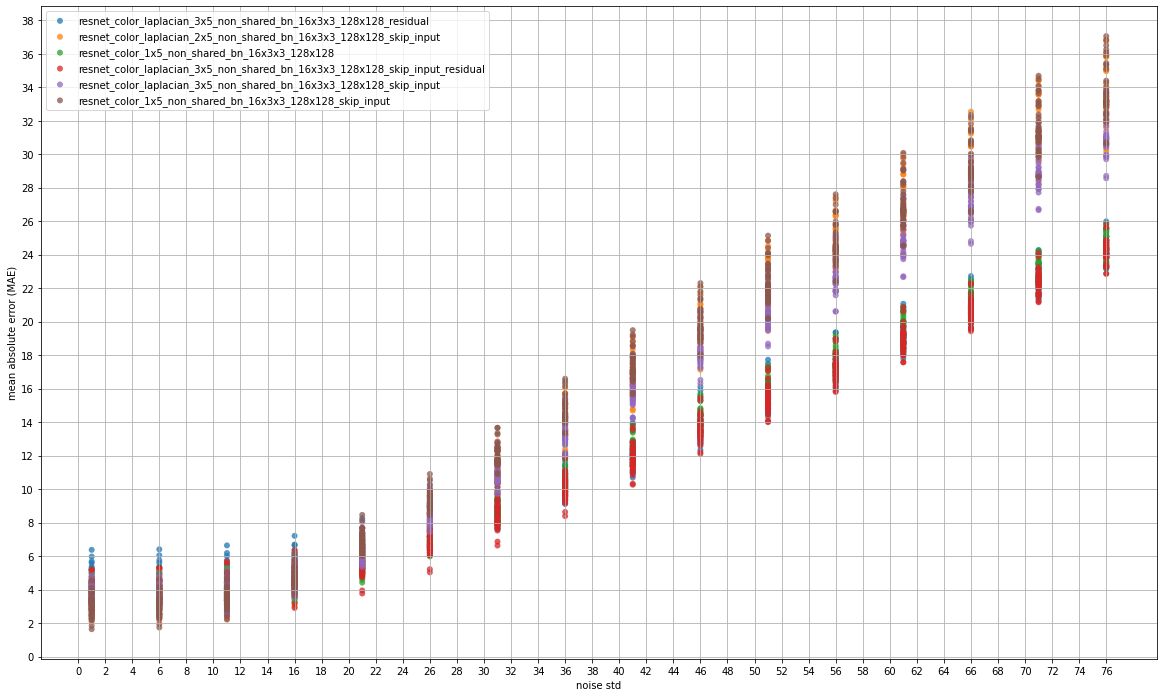

In [8]:
fig = plt.figure(figsize=VISUALIZE_FIG_SIZE)
for label in list(bfcnn.pretrained_models.keys()):
    x = df[df["model_name"]==label]["noise_std"].to_numpy(dtype=np.float)
    y = df[df["model_name"]==label]["mae"].to_numpy(dtype=np.float)
    plt.scatter(
        x=x,
        y=y,
        edgecolor="none",
        alpha=0.75,
        label=label)
    plt.xticks(np.arange(0, max(x)+1, 2.0))
    plt.yticks(np.arange(0, max(y)+1, 2.0))
plt.grid("on")
plt.xlabel("noise std")
plt.ylabel("mean absolute error (MAE)")
plt.legend(list(bfcnn.pretrained_models.keys()))
plt.show()

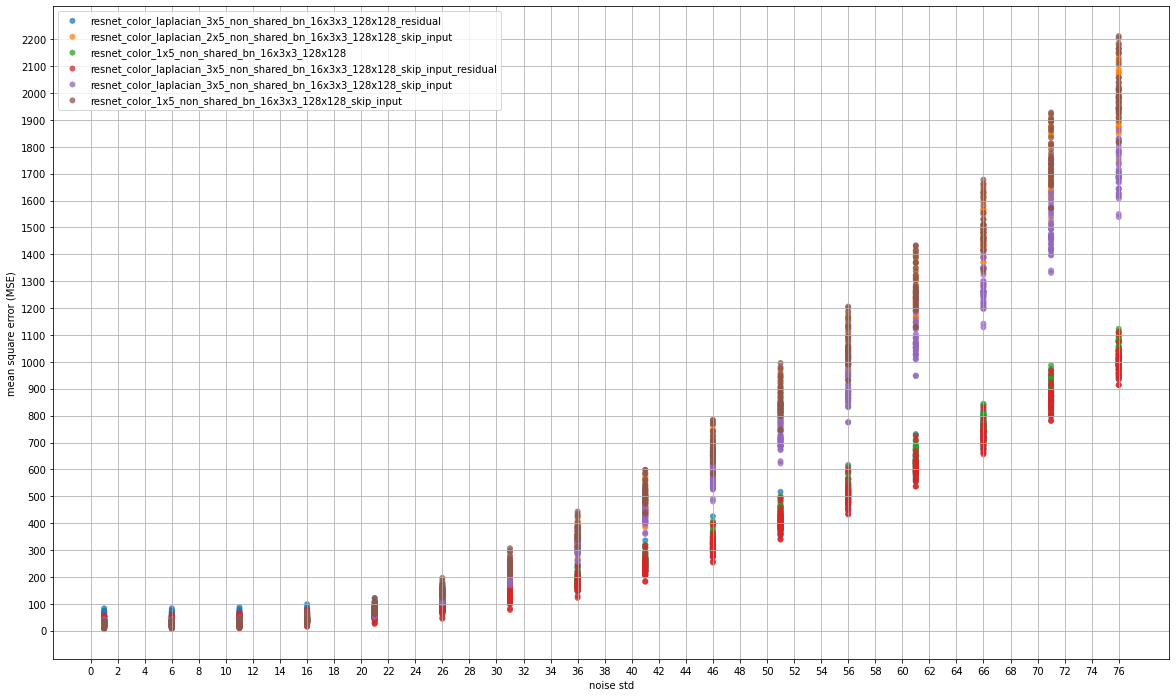

In [9]:
fig = plt.figure(figsize=VISUALIZE_FIG_SIZE)
for label in list(bfcnn.pretrained_models.keys()):
    x = df[df["model_name"]==label]["noise_std"].to_numpy(dtype=np.float)
    y = df[df["model_name"]==label]["mse"].to_numpy(dtype=np.float)
    plt.scatter(
        x=x,
        y=y,
        edgecolor="none",
        alpha=0.75,
        label=label)
    plt.xticks(np.arange(0, max(x)+1, 2.0))
    plt.yticks(np.arange(0, max(y)+1, 100.0))
plt.grid("on")
plt.xlabel("noise std")
plt.ylabel("mean square error (MSE)")
plt.legend(list(bfcnn.pretrained_models.keys()))
plt.show()

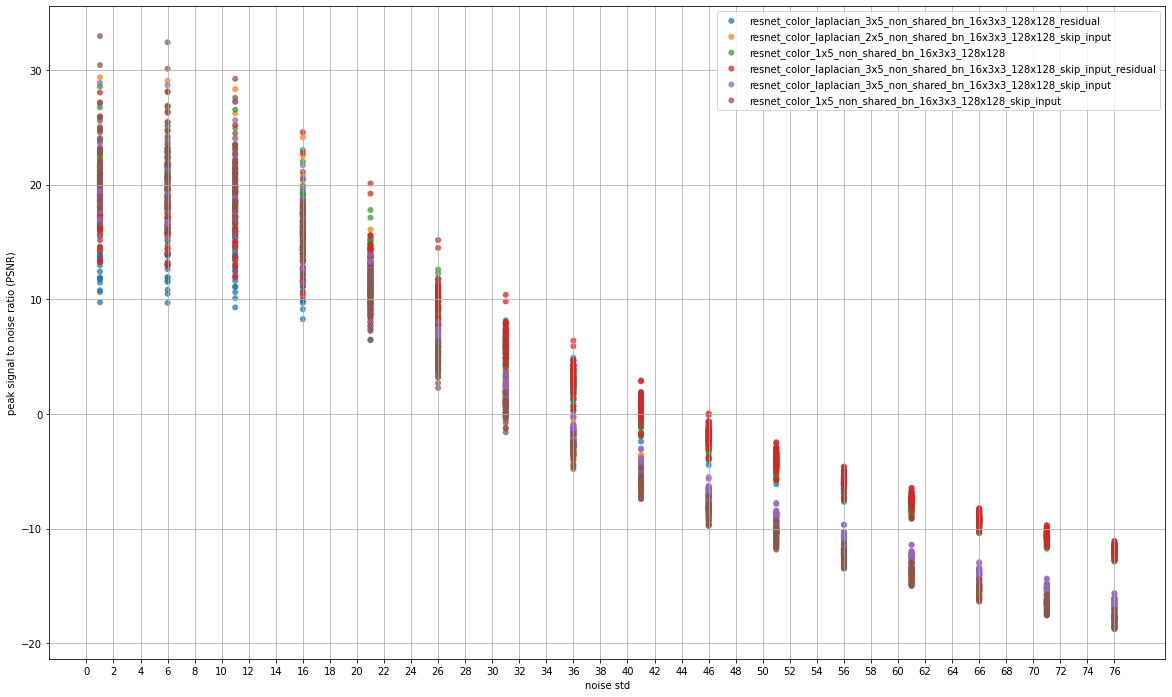

In [10]:
fig = plt.figure(figsize=VISUALIZE_FIG_SIZE)
for label in list(bfcnn.pretrained_models.keys()):
    x = df[df["model_name"]==label]["noise_std"].to_numpy(dtype=np.float)
    y = df[df["model_name"]==label]["mse"].to_numpy(dtype=np.float)
    y = 20 * np.log10(255.0 / (y + 0.0001))
    plt.scatter(
        x=x,
        y=y,
        edgecolor="none",
        alpha=0.75,
        label=label)
    plt.xticks(np.arange(0, max(x)+1, 2.0))
plt.grid("on")
plt.xlabel("noise std")
plt.ylabel("peak signal to noise ratio (PSNR)")
plt.legend(list(bfcnn.pretrained_models.keys()))
plt.show()